In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (accuracy_score, confusion_matrix,classification_report)
from keras.preprocessing.image import ImageDataGenerator

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
#import tarfile
#fname = 'fer2013.tar.gz'
#if fname.endswith("tar.gz"):
#    tar = tarfile.open(fname, "r:gz")
#    tar.extractall()
#    tar.close()
#elif fname.endswith("tar"):
#    tar = tarfile.open(fname, "r:")
#    tar.extractall()
#    tar.close()

In [15]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fer2013.csv")

In [16]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [17]:
df.shape

(35887, 3)

In [18]:
labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'} 

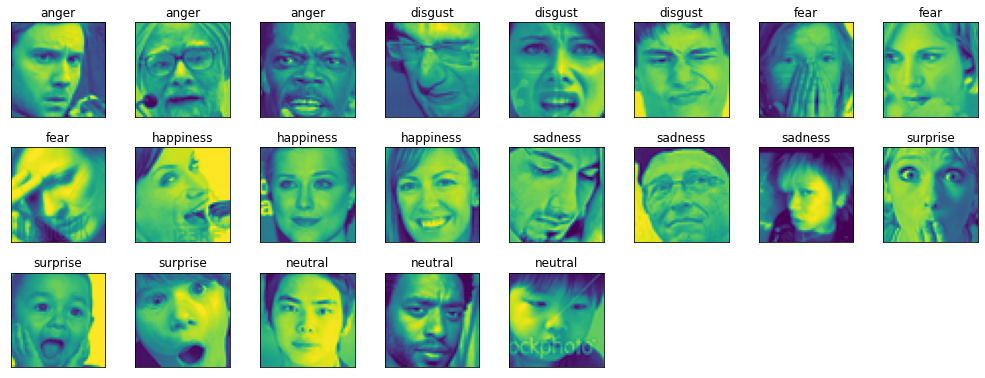

In [19]:
k = 0
figure = plt.figure(1, (14, 14))
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(8, 8, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[label])
        plt.tight_layout()

In [20]:
X_train = df[df['Usage'] == 'Training']['pixels']
y_train = df[df['Usage'] == 'Training']['emotion']
X_test = df[df['Usage'].isin(['PrivateTest','PublicTest'])]['pixels']
y_test = df[df['Usage'].isin(['PrivateTest','PublicTest'])]['emotion']

In [21]:
X_train.shape

(28709,)

In [22]:
X_test.shape

(7178,)

In [23]:
X_train = X_train.apply(lambda x : np.array(x.split(' ')).reshape(48, 48).astype('float32'))
X_train = np.stack(X_train,axis=0)
X_train.shape

(28709, 48, 48)

In [24]:
X_test = X_test.apply(lambda x : np.array(x.split(' ')).reshape(48, 48).astype('float32'))
X_test = np.stack(X_test,axis=0)
X_test.shape

(7178, 48, 48)

**Shapes of Training and Testing Images**

In [25]:
print("Training Image shape: {shape}".format(shape=X_train.shape))
print("Training Image shape: {shape}".format(shape=y_train.shape))
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
print("Test set (labels) shape: {shape}".format(shape=y_test.shape))

Training Image shape: (28709, 48, 48)
Training Image shape: (28709,)
Test set (images) shape: (7178, 48, 48)
Test set (labels) shape: (7178,)


In [26]:
Categories = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

Looking into a random training image.

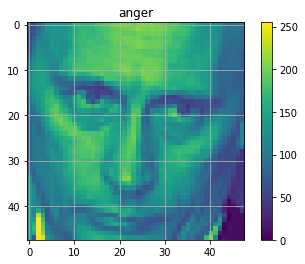

In [31]:
a = np.random.randint(0,100)
plt.figure()
plt.imshow(X_train[a])
plt.title(f"{Categories[y_train[a]]}")
plt.colorbar()
plt.grid(True)
plt.show()

In [32]:
def display_images(images, size=3):
    figsize = (size * len(images), size)
    _, ax = plt.subplots(1, len(images), squeeze=False, figsize=figsize)
    for i, image in enumerate(images):
        ax[0, i].imshow(image)
        
def histogram_images(images, size=3):
    figsize = (size * len(images), size)
    _, ax = plt.subplots(1, len(images), squeeze=False, figsize=figsize)
    for i, image in enumerate(images):
        #image sclicing into 2D. 
        x=image[:,0]
        ax[0, i].hist(x)
        ax[0, i].set_title('Histogram')        

In [33]:
images_list = [X_train[7],X_train[70], X_train[7000],X_test[5000], X_test[6000],X_test[1000]]

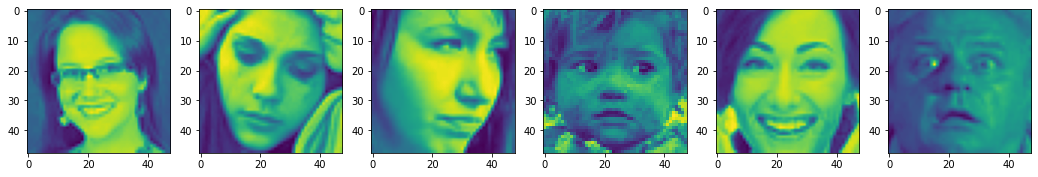

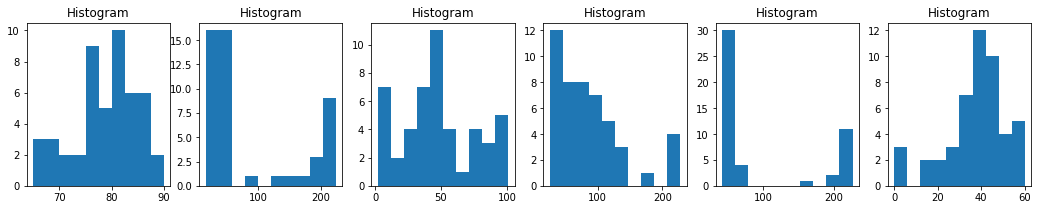

In [34]:
display_images([images_list[i] for i in range(len(images_list))])
histogram_images([images_list[i] for i in range(len(images_list))])

convert into float32 and then rescale the images

In [35]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
train_images = X_train/255.0
test_images = X_test/255.0
train_labels = y_train
test_labels = y_test

In [36]:
y_train

0        0
1        0
2        2
3        4
4        6
        ..
28704    2
28705    0
28706    4
28707    0
28708    4
Name: emotion, Length: 28709, dtype: int64

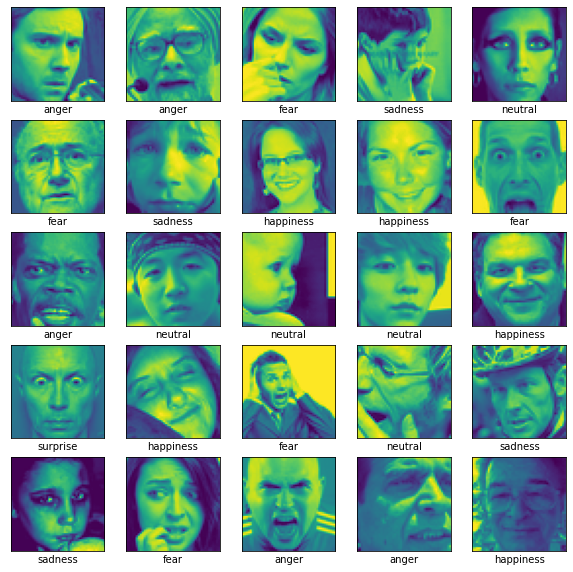

In [37]:
plt.figure(figsize=(10,10))


for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.grid(False)
    plt.xlabel(Categories[train_labels[i]])

reshape the data

In [38]:
train_images = train_images.reshape(-1, 48,48, 1)
test_images = test_images.reshape(-1, 48,48, 1)
print(train_images.shape)
print(test_images.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)


In [39]:
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

In [40]:
from sklearn.model_selection import train_test_split
train_images,valid_images,train_labels,valid_labels = train_test_split(train_images, train_Y_one_hot, test_size=0.2, random_state=12)

In [41]:
print("validation data :",valid_images.shape)

validation data : (5742, 48, 48, 1)


Basic CNN Model

In [85]:
def cnn_model():
    model = tf.keras.Sequential([
            # 1st convolutional layer
            tf.keras.layers.Conv2D(32,kernel_size=(2,2),input_shape=(48,48,1),padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            # Hidden Layer 1    
            tf.keras.layers.Conv2D(64,kernel_size=(2,2),activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            # # Hidden Layer 2 
            tf.keras.layers.Conv2D(16,kernel_size=(2,2),activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            # Output
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dense(256, activation = 'relu'),
            #tf.keras.layers.Dense(128, activation = 'relu'),
            #tf.keras.layers.Dense(64, activation = 'relu'),
            tf.keras.layers.Dense(7, activation = 'relu')

    ])
    return model

In [87]:
model = cnn_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 23, 23, 64)        8256      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 10, 10, 16)        4112      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 5, 5, 16)        

In [88]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.03),loss='categorical_crossentropy',metrics=['accuracy'])

In [89]:
history = model.fit(train_images, train_labels, batch_size=64,epochs=20,verbose=1,validation_data=(valid_images, valid_labels))

Epoch 1/20
359/359 [==============================] - 3s 7ms/step - loss: 7.1718 - accuracy: 0.2507 - val_loss: 7.3208 - val_accuracy: 0.2501
Epoch 2/20
359/359 [==============================] - 2s 6ms/step - loss: 7.1743 - accuracy: 0.2575 - val_loss: 7.3029 - val_accuracy: 0.2712
Epoch 3/20
359/359 [==============================] - 2s 6ms/step - loss: 7.1704 - accuracy: 0.2600 - val_loss: 7.3188 - val_accuracy: 0.2508
Epoch 4/20
359/359 [==============================] - 2s 6ms/step - loss: 7.1765 - accuracy: 0.2528 - val_loss: 7.3163 - val_accuracy: 0.2504
Epoch 5/20
359/359 [==============================] - 2s 6ms/step - loss: 7.1728 - accuracy: 0.2576 - val_loss: 7.3131 - val_accuracy: 0.2691
Epoch 6/20
359/359 [==============================] - 2s 6ms/step - loss: 7.1632 - accuracy: 0.2715 - val_loss: 7.3528 - val_accuracy: 0.2501
Epoch 7/20
359/359 [==============================] - 2s 6ms/step - loss: 7.1830 - accuracy: 0.2516 - val_loss: 7.3211 - val_accuracy: 0.2501
Epoch 

**Training and Testing Loss Graphs**

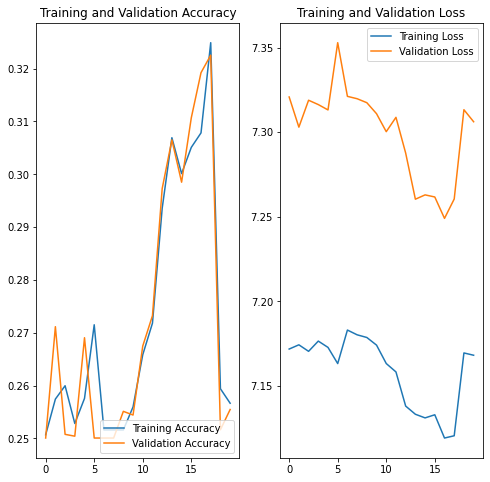

In [90]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Early Stopping**

In [92]:
model1 = cnn_model()
model1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss')

In [96]:

history1 = model1.fit(train_images, train_labels, batch_size=16,epochs=1000,verbose=1,validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

Epoch 1/1000
1436/1436 [==============================] - 7s 5ms/step - loss: 1.8701 - accuracy: 0.3354 - val_loss: 1.8997 - val_accuracy: 0.3473
Epoch 2/1000
1436/1436 [==============================] - 6s 4ms/step - loss: 1.9128 - accuracy: 0.2895 - val_loss: 1.8747 - val_accuracy: 0.3316


In [97]:
# lets try to evaluate the model on testing data
test_eval = model1.evaluate(test_images, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.8613951206207275
Test accuracy: 0.3397882282733917


In [98]:
# lets try to predict the classes
y_pred = model1.predict(test_images)
y_pred = np.argmax(np.round(y_pred),axis=1)
target_names = ["{}".format(Categories[i]) for i in range(7)]
print ("\nClassification report : \n", classification_report(y_test, y_pred, target_names=target_names))


Classification report : 
               precision    recall  f1-score   support

       anger       0.22      0.10      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.23      0.21      0.22      1024
   happiness       0.35      0.77      0.48      1774
     sadness       0.30      0.17      0.21      1247
    surprise       0.54      0.23      0.32       831
     neutral       0.32      0.22      0.26      1233

    accuracy                           0.33      7178
   macro avg       0.28      0.24      0.23      7178
weighted avg       0.32      0.33      0.29      7178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
predicted_classes = model.predict(X_test)

In [100]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [101]:
predicted_classes.shape, y_test.shape

((7178,), (7178,))

In [102]:
y_test.iloc[7]

0

Found 1775 correct labels


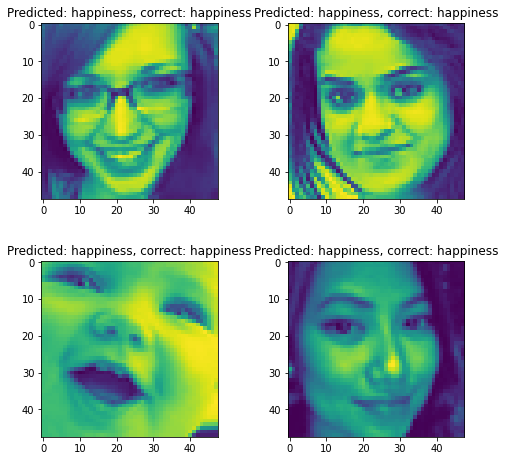

In [103]:
correct = np.where(predicted_classes==y_test)[0]
plt.figure(figsize=(7,7))
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[correct].reshape(48,48), interpolation='none')
    plt.title("Predicted: {}, correct: {}".format(Categories[predicted_classes[correct]], Categories[y_test.iloc[correct]]))
    plt.tight_layout()

Found 5403 correct labels


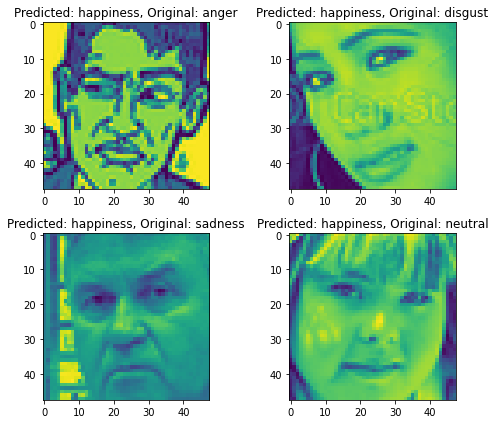

In [104]:
incorrect = np.where(predicted_classes!=y_test)[0]
print("Found %d correct labels" % len(incorrect))
plt.figure(figsize=(7,6))
for i, incorrect in enumerate(incorrect[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(48,48), interpolation='none')
    plt.title("Predicted: {}, Original: {}".format(Categories[predicted_classes[incorrect]], Categories[y_test.iloc[incorrect]]))
    plt.tight_layout()

**Building A CNN function with Hyperparameter Function**

In [105]:
def build_model_arguments(Dropoutt, Optimizer_, Activation_Function, Initiliazer, Kernel_Size_, Padding_):
    model = tf.keras.Sequential([
            # 1st convolutional layer
            tf.keras.layers.Conv2D(64,kernel_size=Kernel_Size_,input_shape=(48,48,1),activation=Activation_Function, padding=Padding_, kernel_initializer=Initiliazer),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(Dropoutt),

            # 2nd convolutional layer    
            tf.keras.layers.Conv2D(128,kernel_size=Kernel_Size_,activation=Activation_Function, padding=Padding_, kernel_initializer=Initiliazer),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(Dropoutt),

            # 3rd convolutional layer
            tf.keras.layers.Conv2D(256,kernel_size=Kernel_Size_,activation=Activation_Function, padding=Padding_, kernel_initializer=Initiliazer),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(Dropoutt),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation = Activation_Function),
            tf.keras.layers.Dropout(Dropoutt),
            tf.keras.layers.Dense(128, activation = Activation_Function),
            tf.keras.layers.Dense(64, activation = Activation_Function),

            tf.keras.layers.Dense(7, activation = 'softmax')
    ])


    # Model Compile
    model.compile(optimizer=Optimizer_,loss='categorical_crossentropy',metrics=['accuracy'])
    EPOCHS = 20

    history = model.fit(train_images, train_labels, batch_size=32,epochs=EPOCHS,verbose=1,validation_data=(valid_images, valid_labels))
    

    # Graphs 
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    # lets try to evaluate the model on testing data
    test_eval = model.evaluate(test_images, test_Y_one_hot, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])
    
    # lets try to predict the classes
    y_pred = model.predict(test_images)
    y_pred = np.argmax(np.round(y_pred),axis=1)
    target_names = ["{}".format(Categories[i]) for i in range(7)]
    print ("\nClassification report : \n", classification_report(y_test, y_pred, target_names=target_names))
    return Dropoutt, Optimizer_, Activation_Function, Initiliazer, Kernel_Size_, Padding_, test_eval[1]

**Hyperparameter Tunings**

Epoch 1/20
718/718 [==============================] - 10s 13ms/step - loss: 1.7978 - accuracy: 0.2690 - val_loss: 1.7275 - val_accuracy: 0.3307
Epoch 2/20
718/718 [==============================] - 9s 13ms/step - loss: 1.6106 - accuracy: 0.3677 - val_loss: 1.4887 - val_accuracy: 0.4244
Epoch 3/20
718/718 [==============================] - 10s 14ms/step - loss: 1.5013 - accuracy: 0.4167 - val_loss: 1.4178 - val_accuracy: 0.4528
Epoch 4/20
718/718 [==============================] - 9s 13ms/step - loss: 1.4236 - accuracy: 0.4491 - val_loss: 1.3733 - val_accuracy: 0.4671
Epoch 5/20
718/718 [==============================] - 9s 13ms/step - loss: 1.3611 - accuracy: 0.4767 - val_loss: 1.2929 - val_accuracy: 0.5017
Epoch 6/20
718/718 [==============================] - 9s 12ms/step - loss: 1.3115 - accuracy: 0.5024 - val_loss: 1.2509 - val_accuracy: 0.5200
Epoch 7/20
718/718 [==============================] - 9s 12ms/step - loss: 1.2677 - accuracy: 0.5200 - val_loss: 1.2442 - val_accuracy: 0.52

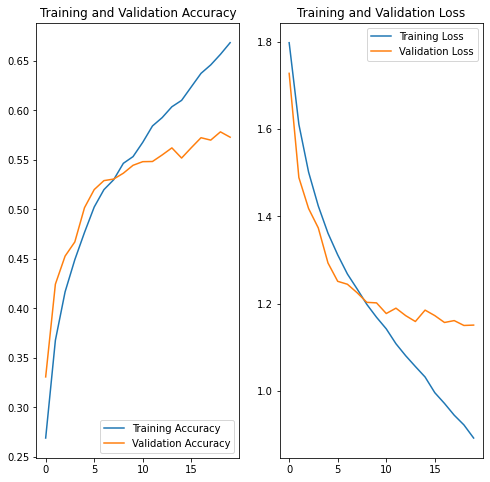

Test loss: 1.1393704414367676
Test accuracy: 0.5766230225563049

Classification report : 
               precision    recall  f1-score   support

       anger       0.23      0.82      0.36       958
     disgust       0.95      0.32      0.47       111
        fear       0.57      0.24      0.34      1024
   happiness       0.83      0.75      0.79      1774
     sadness       0.55      0.22      0.32      1247
    surprise       0.84      0.65      0.73       831
     neutral       0.68      0.29      0.40      1233

    accuracy                           0.50      7178
   macro avg       0.66      0.47      0.49      7178
weighted avg       0.64      0.50      0.51      7178



In [106]:
cnn_results1 = build_model_arguments(Dropoutt=0.3, Optimizer_='Adam', Activation_Function='relu', Initiliazer='random_normal', Kernel_Size_=(4,4), Padding_='same')

Epoch 1/20
718/718 [==============================] - 12s 16ms/step - loss: 1.8502 - accuracy: 0.2414 - val_loss: 1.8105 - val_accuracy: 0.2501
Epoch 2/20
718/718 [==============================] - 9s 13ms/step - loss: 1.7449 - accuracy: 0.2902 - val_loss: 1.6609 - val_accuracy: 0.3342
Epoch 3/20
718/718 [==============================] - 9s 13ms/step - loss: 1.6381 - accuracy: 0.3612 - val_loss: 1.6001 - val_accuracy: 0.3614
Epoch 4/20
718/718 [==============================] - 10s 13ms/step - loss: 1.5751 - accuracy: 0.3875 - val_loss: 1.5004 - val_accuracy: 0.4197
Epoch 5/20
718/718 [==============================] - 9s 13ms/step - loss: 1.5300 - accuracy: 0.4076 - val_loss: 1.4550 - val_accuracy: 0.4380
Epoch 6/20
718/718 [==============================] - 9s 13ms/step - loss: 1.4897 - accuracy: 0.4208 - val_loss: 1.4360 - val_accuracy: 0.4458
Epoch 7/20
718/718 [==============================] - 9s 13ms/step - loss: 1.4489 - accuracy: 0.4424 - val_loss: 1.3948 - val_accuracy: 0.45

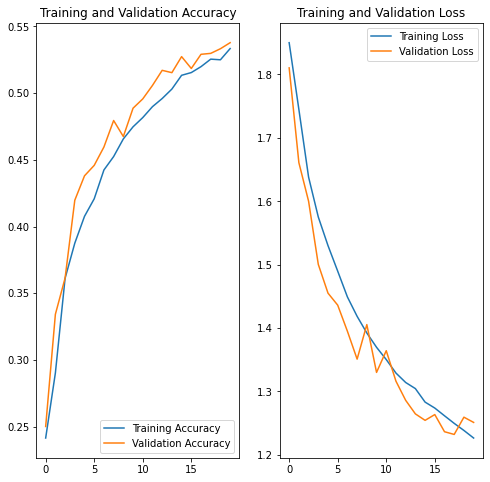

Test loss: 1.2392908334732056
Test accuracy: 0.5399832725524902

Classification report : 
               precision    recall  f1-score   support

       anger       0.22      0.76      0.34       958
     disgust       0.70      0.23      0.35       111
        fear       0.66      0.08      0.14      1024
   happiness       0.73      0.80      0.76      1774
     sadness       0.59      0.10      0.17      1247
    surprise       0.71      0.67      0.69       831
     neutral       0.61      0.36      0.45      1233

    accuracy                           0.47      7178
   macro avg       0.60      0.43      0.41      7178
weighted avg       0.60      0.47      0.45      7178



In [108]:
cnn_results2 = build_model_arguments(Dropoutt=0.6, Optimizer_='Adamax', Activation_Function='LeakyReLU', Initiliazer='random_normal', Kernel_Size_=(4,4), Padding_='same')

Epoch 1/20
718/718 [==============================] - 7s 9ms/step - loss: 1.8250 - accuracy: 0.2437 - val_loss: 1.8159 - val_accuracy: 0.2503
Epoch 2/20
718/718 [==============================] - 6s 8ms/step - loss: 1.8084 - accuracy: 0.2507 - val_loss: 1.8044 - val_accuracy: 0.2508
Epoch 3/20
718/718 [==============================] - 6s 8ms/step - loss: 1.7980 - accuracy: 0.2482 - val_loss: 1.8472 - val_accuracy: 0.2558
Epoch 4/20
718/718 [==============================] - 6s 8ms/step - loss: 1.7857 - accuracy: 0.2556 - val_loss: 1.8588 - val_accuracy: 0.2584
Epoch 5/20
718/718 [==============================] - 6s 8ms/step - loss: 1.7699 - accuracy: 0.2665 - val_loss: 1.9102 - val_accuracy: 0.2616
Epoch 6/20
718/718 [==============================] - 6s 8ms/step - loss: 1.7460 - accuracy: 0.2837 - val_loss: 2.0659 - val_accuracy: 0.2628
Epoch 7/20
718/718 [==============================] - 6s 8ms/step - loss: 1.7117 - accuracy: 0.3067 - val_loss: 1.9813 - val_accuracy: 0.3076
Epoch 

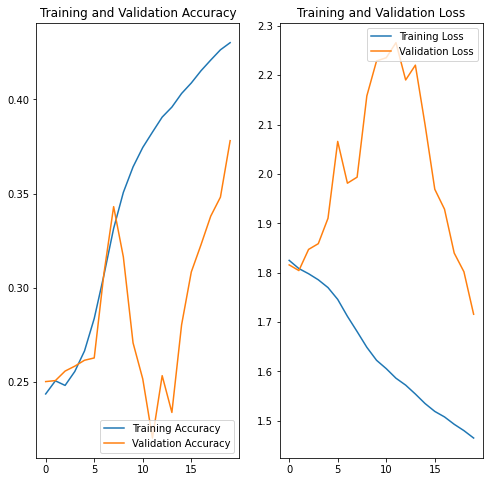

Test loss: 1.6996126174926758
Test accuracy: 0.3914739489555359

Classification report : 
               precision    recall  f1-score   support

       anger       0.17      0.62      0.27       958
     disgust       0.10      0.25      0.14       111
        fear       0.40      0.00      0.00      1024
   happiness       0.55      0.60      0.57      1774
     sadness       0.53      0.02      0.03      1247
    surprise       0.63      0.51      0.57       831
     neutral       0.42      0.28      0.33      1233

    accuracy                           0.34      7178
   macro avg       0.40      0.32      0.27      7178
weighted avg       0.45      0.34      0.31      7178



In [107]:
cnn_results3 = build_model_arguments(Dropoutt=0.25, Optimizer_='sgd', Activation_Function='tanh', Initiliazer='he_normal', Kernel_Size_=(2,2), Padding_='valid')

In [109]:
results = [cnn_results1,cnn_results2,cnn_results3]
df_results = pd.DataFrame(results,columns=['Dropout','Optimizer','Activation_Function','Initiliazer','Kernel_Size','Padding', 'Accuracy'])

With the Hyperparaeter Tuning we are getting higher accuracy for the first model which cnn1 model so now we are prdicting classes and showing images

Applying Data Augmentation 

In [115]:
def build_model_augmented():
    model = tf.keras.Sequential([
            # 1st layer
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(48,48,1),activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(0.25),

            # 2nd layer    
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(0.25),

            # 3rd layer
            tf.keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation = 'relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
        
            tf.keras.layers.Dense(64, activation = 'relu'),

            tf.keras.layers.Dense(7, activation = 'softmax')
    ])
    return model

In [116]:
gen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, 
                         rotation_range=0, width_shift_range=0.1, shear_range=0, 
                         height_shift_range=0.1, zoom_range=0., fill_mode='nearest')

**fitting the Model**

In [117]:
gen.fit(train_images)
aug_model = build_model_augmented()

In [118]:
aug_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [119]:
EPOCHS = 20
batch = 128

aug_history= aug_model.fit(gen.flow(train_images, train_labels,batch_size=batch),epochs=EPOCHS,validation_data=(valid_images, valid_labels),
                    steps_per_epoch=train_images.shape[0] // batch)

Epoch 1/20
179/179 [==============================] - 11s 54ms/step - loss: 2.0592 - accuracy: 0.2102 - val_loss: 2.0373 - val_accuracy: 0.2501
Epoch 2/20
179/179 [==============================] - 10s 57ms/step - loss: 1.8389 - accuracy: 0.2456 - val_loss: 1.8988 - val_accuracy: 0.2501
Epoch 3/20
179/179 [==============================] - 9s 53ms/step - loss: 1.7732 - accuracy: 0.2792 - val_loss: 1.8061 - val_accuracy: 0.2609
Epoch 4/20
179/179 [==============================] - 9s 51ms/step - loss: 1.6947 - accuracy: 0.3223 - val_loss: 2.1134 - val_accuracy: 0.2645
Epoch 5/20
179/179 [==============================] - 10s 54ms/step - loss: 1.5985 - accuracy: 0.3697 - val_loss: 1.6444 - val_accuracy: 0.3847
Epoch 6/20
179/179 [==============================] - 9s 52ms/step - loss: 1.5018 - accuracy: 0.4089 - val_loss: 1.4809 - val_accuracy: 0.4303
Epoch 7/20
179/179 [==============================] - 10s 54ms/step - loss: 1.4298 - accuracy: 0.4429 - val_loss: 1.3729 - val_accuracy: 0.

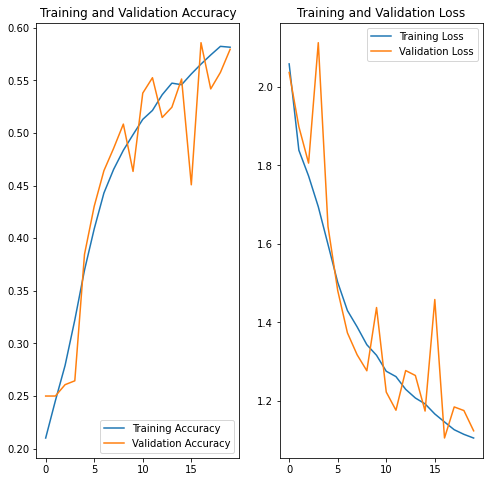

In [121]:
training_accuracy = aug_history.history['accuracy']
validation_accuracy = aug_history.history['val_accuracy']

training_loss = aug_history.history['loss']
validation_loss = aug_history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [122]:
test_eval = aug_model.evaluate(test_images, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.0769504308700562
Test accuracy: 0.5922262668609619


In [ ]:
np.squeeze(np.argwhere(y_test.iloc[0]==0))

array([], dtype=int64)

In [ ]:
y_test[y_test == 0]

28709    0
28716    0
28718    0
28720    0
28726    0
        ..
35845    0
35849    0
35854    0
35881    0
35884    0
Name: emotion, Length: 958, dtype: int64

Found 1660 correct labels


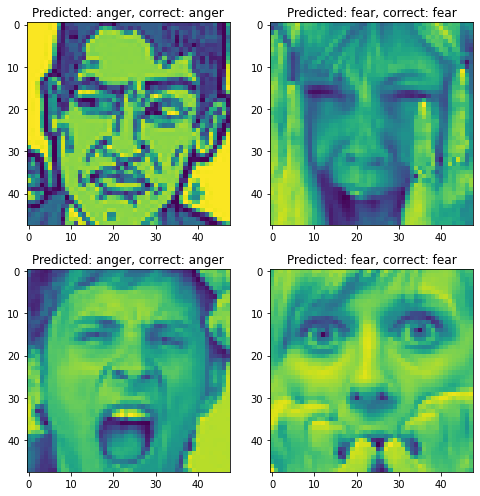

In [123]:
predicted_classes = aug_model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test.shape
plt.figure(figsize=(7,7))
correct = np.where(predicted_classes==y_test)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[correct].reshape(48,48), interpolation='none')
    plt.title("Predicted: {}, correct: {}".format(Categories[predicted_classes[correct]], Categories[y_test.iloc[correct]]))
    plt.tight_layout()

Found 5518 incorrect labels


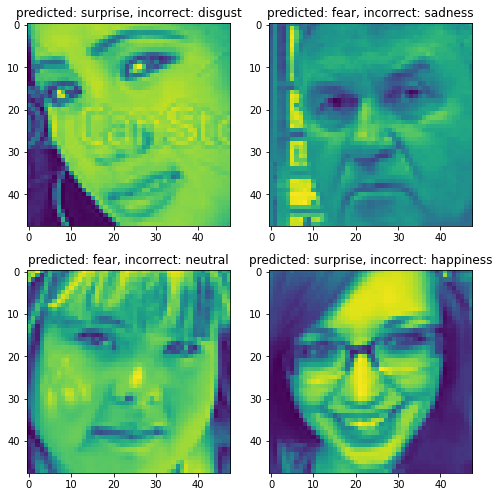

In [125]:
predicted_classes = aug_model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test.shape
incorrect = np.where(predicted_classes!=y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
plt.figure(figsize=(7,7))
for i, incorrect in enumerate(incorrect[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(48,48), interpolation='none')
    plt.title("predicted: {}, incorrect: {}".format(Categories[predicted_classes[incorrect]], Categories[y_test.iloc[incorrect]]))
    plt.tight_layout()